In [15]:
import os
import sys
import requests

# Add the `scripts` directory to the Python path
current_dir = os.path.dirname(os.path.abspath("__file__"))
scripts_dir = os.path.abspath(os.path.join(current_dir, "../"))
sys.path.append(scripts_dir)

# Import the generate_tabular_test_files function
from generate_input_files.generate_tabular_test_files import generate_tabular_test_files


Make sure the API is running on localhost:8000 - Without Authentication!!

In [ ]:
root_dir = os.path.abspath("../..")
tmp_folder = os.path.join(root_dir, "tmp", "tabular_test")

# Call the function to generate files
print("Generating tabular test files...")
generated_files = generate_tabular_test_files(tmp_folder)
print("File generation completed.")

# Extract file paths
dataset_filename = generated_files["dataset"]
yaml_filename = generated_files["yaml"]
model_filename = generated_files["model"]

# Cell 3: Submit the training job using the API
# Define the API URL
API_URL = "http://localhost:8000/developer/submit_job_by_model_and_data"

# Prepare the files and data for the request
files = {
    "model": open(model_filename, "rb"),
    "dataset": open(dataset_filename, "rb"),
    "dataset_definition": open(yaml_filename, "rb"),
}
data = {
    "framework": "TensorFlow 2.16.1",
    "model_name": "tabular_analysis_model",
    "epochs": 50,
}

# Send the POST request
print("Submitting the training job to the API...")
response = requests.post(API_URL, files=files, data=data)
print(f"Submitted: {response.status_code} {response.text}")


Generating tabular test files...
Dataset saved to c:\Users\wiebe\Desktop\.ugent20242025\masterproef_local\AIBoMGen-experiments\tmp\tabular_test\winequality.csv
Dataset definition saved to c:\Users\wiebe\Desktop\.ugent20242025\masterproef_local\AIBoMGen-experiments\tmp\tabular_test\winequality_definition.yaml
Model saved to c:\Users\wiebe\Desktop\.ugent20242025\masterproef_local\AIBoMGen-experiments\tmp\tabular_test\winequality_model.keras
File generation completed.
Submitting the training job to the API...
Submitted: 200 {"job_id":"0348f9d0-1762-4a7b-b7a7-242674e41039","status":"Training started","unique_dir":"b98ed616-6f7a-43dc-9673-afda08bd7044"}


When the job is finished, all the artifacts are available on MinIO: localhost:9001. You should download them from there and place them in the Minio folder to further analyse the results.

In [38]:
import boto3
import os
import time
from generate_input_files.download_results import initialize_s3_client, wait_for_job_and_download

MINIO_URL = "http://localhost:9000"
ACCESS_KEY = "minio_user"  # Replace with your MinIO access key
SECRET_KEY = "minio_password"  # Replace with your MinIO secret key
BUCKET_NAME = "training-jobs"
DOWNLOAD_DIR = os.path.join(root_dir, "results", "basic_eval" ,"tabular_test")

# Initialize the S3 client
s3_client = initialize_s3_client(MINIO_URL, ACCESS_KEY, SECRET_KEY)

# Extract the unique_dir from the API response
response_data = response.json()  # Assuming the API response is JSON
unique_dir = response_data.get("unique_dir")  # Replace with the actual key for the unique directory

if unique_dir:
    # Wait for the job to finish and download the folder
    wait_for_job_and_download(s3_client, BUCKET_NAME, unique_dir, DOWNLOAD_DIR)
else:
    print("Error: 'unique_dir' not found in the API response.")

Checking if job is finished by looking for 'output' folder in 'b98ed616-6f7a-43dc-9673-afda08bd7044'...
Job is not yet finished. Retrying in 10 seconds...
Checking if job is finished by looking for 'output' folder in 'b98ed616-6f7a-43dc-9673-afda08bd7044'...
Job is not yet finished. Retrying in 10 seconds...
Checking if job is finished by looking for 'output' folder in 'b98ed616-6f7a-43dc-9673-afda08bd7044'...
Downloaded: b98ed616-6f7a-43dc-9673-afda08bd7044/dataset/winequality.csv -> c:\Users\wiebe\Desktop\.ugent20242025\masterproef_local\AIBoMGen-experiments\results\basic_eval\tabular_test\b98ed616-6f7a-43dc-9673-afda08bd7044/dataset/winequality.csv
Downloaded: b98ed616-6f7a-43dc-9673-afda08bd7044/definition/winequality_definition.yaml -> c:\Users\wiebe\Desktop\.ugent20242025\masterproef_local\AIBoMGen-experiments\results\basic_eval\tabular_test\b98ed616-6f7a-43dc-9673-afda08bd7044/definition/winequality_definition.yaml
Downloaded: b98ed616-6f7a-43dc-9673-afda08bd7044/model/winequali

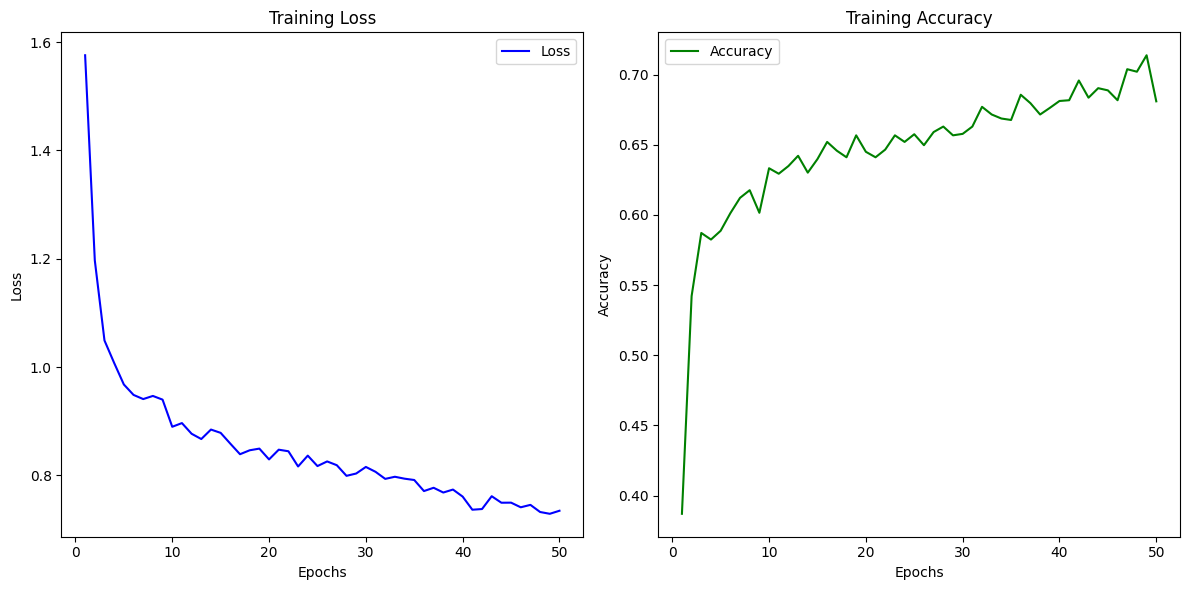


Contents of c:\Users\wiebe\Desktop\.ugent20242025\masterproef_local\AIBoMGen-experiments\results\basic_eval\tabular_test\b98ed616-6f7a-43dc-9673-afda08bd7044\output\logs.log:
2025-05-24 10:40:17,396 - INFO - Grouped BOM data generated successfully.
2025-05-24 10:40:17,396 - INFO - Transforming BOM data to CycloneDX format...
2025-05-24 10:40:17,452 - INFO - Signing BOM data...
2025-05-24 10:40:17,460 - INFO - BOM signed
2025-05-24 10:40:17,460 - INFO - serializing BOM data...
2025-05-24 10:40:17,552 - INFO - BOM serialized: /tmp/b98ed616-6f7a-43dc-9673-afda08bd7044/cyclonedx_bom.json
2025-05-24 10:40:17,552 - INFO - Uploading bom to MinIO...
2025-05-24 10:40:17,569 - INFO - Task completed successfully.
2025-05-24 10:40:17,569 - INFO - Task 0348f9d0-1762-4a7b-b7a7-242674e41039 completed.
2025-05-24 10:40:17,569 - INFO - Uploading application_logs to MinIO. Size: 4717 bytes

Contents of c:\Users\wiebe\Desktop\.ugent20242025\masterproef_local\AIBoMGen-experiments\results\basic_eval\tabul

In [39]:
import os
import json
import matplotlib.pyplot as plt

# Define the paths to the downloaded files
output_dir = os.path.join(root_dir, "results", "basic_eval", "tabular_test", unique_dir, "output")
metrics_file = os.path.join(output_dir, "metrics.json")
logs_file = os.path.join(output_dir, "logs.log")
cyclonedx_file = os.path.join(output_dir, "cyclonedx_bom.json")

# Load and plot metrics.json
if os.path.exists(metrics_file):
    with open(metrics_file, "r") as f:
        metrics = json.load(f)
    
    # Example: Plot training loss and accuracy
    if "loss" in metrics and "accuracy" in metrics:
        epochs = range(1, len(metrics["loss"]) + 1)
        
        plt.figure(figsize=(12, 6))
        
        # Plot loss
        plt.subplot(1, 2, 1)
        plt.plot(epochs, metrics["loss"], label="Loss", color="blue")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.title("Training Loss")
        plt.legend()
        
        # Plot accuracy
        plt.subplot(1, 2, 2)
        plt.plot(epochs, metrics["accuracy"], label="Accuracy", color="green")
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.title("Training Accuracy")
        plt.legend()
        
        plt.tight_layout()
        plt.show()
    else:
        print("Metrics file does not contain 'loss' or 'accuracy'.")
else:
    print(f"Metrics file not found at {metrics_file}.")

# Analyze logs.log
if os.path.exists(logs_file):
    print(f"\nContents of {logs_file}:")
    with open(logs_file, "r") as f:
        logs = f.readlines()
        for line in logs[-10:]:  # Print the last 10 lines of the log file
            print(line.strip())
else:
    print(f"Logs file not found at {logs_file}.")

# Analyze cyclonedx_bom.json
if os.path.exists(cyclonedx_file):
    print(f"\nContents of {cyclonedx_file}:")
    with open(cyclonedx_file, "r") as f:
        cyclonedx_data = json.load(f)
        # Example: Print the first few keys in the BOM file
        print(json.dumps(cyclonedx_data, indent=4)[:500])  # Print the first 500 characters
else:
    print(f"CycloneDX BOM file not found at {cyclonedx_file}.")